In [51]:
import sys 
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent / 'statistics_server'))
import plotly.graph_objects as go

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import rcParams
from prophet import Prophet
from matplotlib.ticker import FuncFormatter

from psql_client import PSQLClient

sql_client = PSQLClient(
	host='localhost',
	port=5432,
	user='default',
	password='12345',
	dbname='hack',
)

In [52]:
df = sql_client.select_df("""
select 	spgz_name,
		date_trunc('quarter', start_report_date_quarter) + interval '3 month' as report_date,
        sum(turnovers_debit_quantity) as turnovers_debit_quantity,
        sum(turnovers_debit_price) as turnovers_debit_price,
		sum(turnovers_credit_quantity) as turnovers_credit_quantity,
		sum(turnovers_credit_price) as turnovers_credit_price,
		sum(saldo_end_debit_quantity) as saldo_end_debit_quantity,
		sum(saldo_end_debit_price) as saldo_end_debit_price,
		max(last_saldo_end_debit_quantity) as last_saldo_end_debit_quantity,
		max(last_saldo_end_debit_price) as last_saldo_end_debit_price
	from financial_quarter_data
	where spgz_name = 'Адаптер (переходник) USB-COM, шт'
	group by spgz_name, date_trunc('quarter', start_report_date_quarter)
	order by spgz_name, date_trunc('quarter', start_report_date_quarter);
""")
df

,spgz_name,report_date,turnovers_debit_quantity,turnovers_debit_price,turnovers_credit_quantity,turnovers_credit_price,saldo_end_debit_quantity,saldo_end_debit_price,last_saldo_end_debit_quantity,last_saldo_end_debit_price
0,"Адаптер (переходник) USB-COM, шт",2022-01-01 00:00:00+00:00,0,0,11.00,6095.13,246.00,199010.74,225.00,198904.75
1,"Адаптер (переходник) USB-COM, шт",2022-04-01 00:00:00+00:00,0,0,3.00,1335.61,243.00,197675.13,225.00,198904.75
2,"Адаптер (переходник) USB-COM, шт",2022-07-01 00:00:00+00:00,48.00,26761.72,39.00,16264.93,252.00,208171.92,225.00,198904.75
3,"Адаптер (переходник) USB-COM, шт",2022-10-01 00:00:00+00:00,180.00,35274.95,207.00,44542.12,225.00,198904.75,225.00,198904.75


### Прогноз

In [53]:
weights = np.array(range(1, df.shape[0]+1)) ** 5
last_saldo_end_debit_quantity = int(df['last_saldo_end_debit_quantity'].head(1).item())
last_saldo_end_debit_price = float(df['last_saldo_end_debit_price'].head(1).item())
avg_turnovers_credit_quantity = int(np.average(df.sort_values('report_date')['turnovers_credit_quantity'].values, weights=weights))
avg_turnovers_credit_price = float(np.average(df.sort_values('report_date')['turnovers_credit_price'].values, weights=weights))
avg_saldo_credit_quantity = int(np.average(df.sort_values('report_date')['saldo_end_debit_quantity'].values, weights=weights))
avg_saldo_credit_price = float(np.average(df.sort_values('report_date')['saldo_end_debit_price'].values, weights=weights))
print(last_saldo_end_debit_quantity)
print(last_saldo_end_debit_price)
print(avg_turnovers_credit_quantity)
print(avg_turnovers_credit_price)
print(avg_saldo_credit_quantity)
print(avg_saldo_credit_price)

225
198904.75
170
38163.34116923077
230
200606.81189230768


In [7]:
print(avg_saldo_credit_quantity - (last_saldo_end_debit_quantity - avg_turnovers_credit_quantity))
print(avg_saldo_credit_price - (last_saldo_end_debit_price - avg_turnovers_credit_price))

175
39865.40306153844


### Визуализация остатков

In [55]:
df['report_date'] = df['report_date'].dt.quarter.apply(lambda x: f'Q{x}')
cols_to_convert = [
    'turnovers_debit_quantity',
       'turnovers_debit_price', 'turnovers_credit_quantity',
       'turnovers_credit_price', 'saldo_end_debit_quantity',
       'saldo_end_debit_price', 'last_saldo_end_debit_quantity',
       'last_saldo_end_debit_price'
]
df[cols_to_convert] = df[cols_to_convert].astype(float)
df = df.sort_values(by='report_date')
df

,spgz_name,report_date,turnovers_debit_quantity,turnovers_debit_price,turnovers_credit_quantity,turnovers_credit_price,saldo_end_debit_quantity,saldo_end_debit_price,last_saldo_end_debit_quantity,last_saldo_end_debit_price
0,"Адаптер (переходник) USB-COM, шт",Q1,0.0,0.00,11.0,6095.13,246.0,199010.74,225.0,198904.75
1,"Адаптер (переходник) USB-COM, шт",Q2,0.0,0.00,3.0,1335.61,243.0,197675.13,225.0,198904.75
2,"Адаптер (переходник) USB-COM, шт",Q3,48.0,26761.72,39.0,16264.93,252.0,208171.92,225.0,198904.75
3,"Адаптер (переходник) USB-COM, шт",Q4,180.0,35274.95,207.0,44542.12,225.0,198904.75,225.0,198904.75


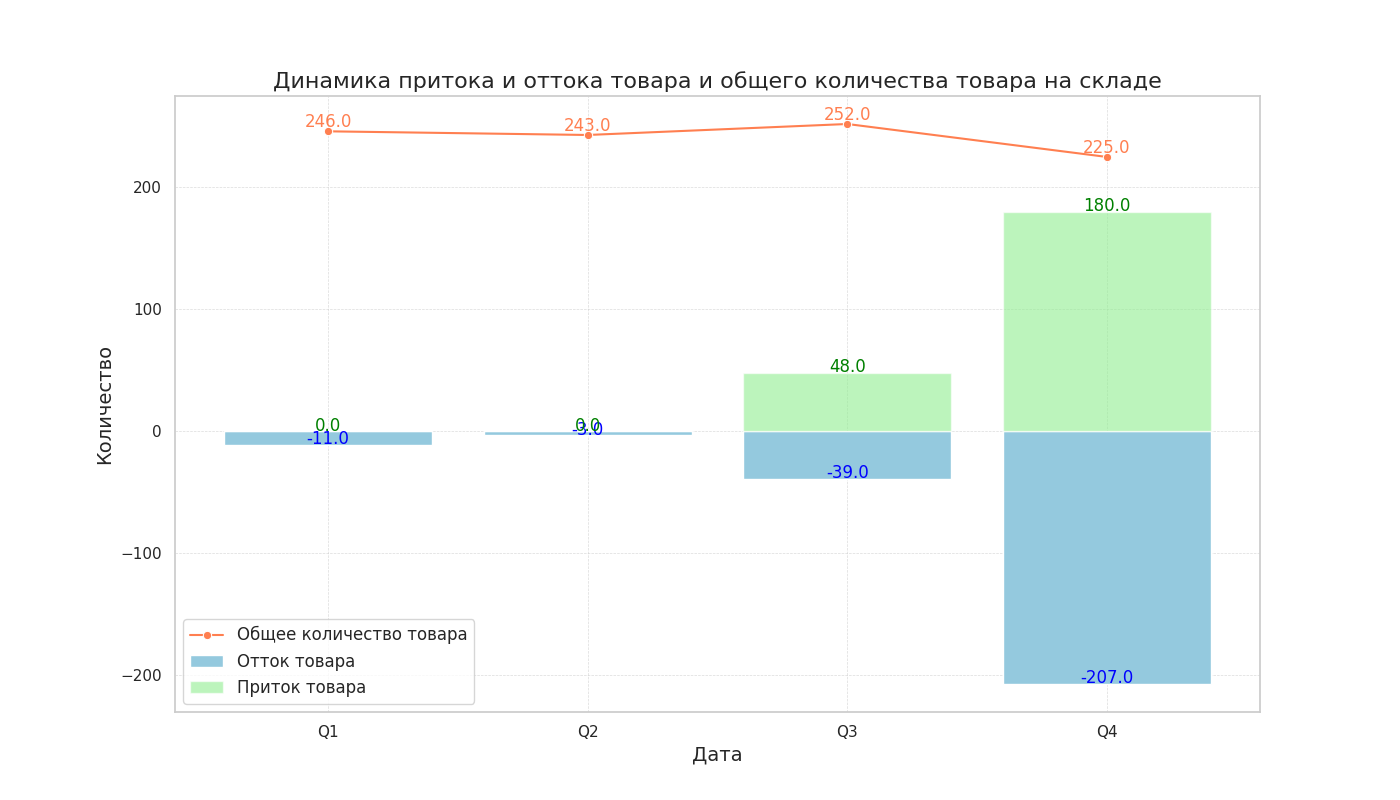

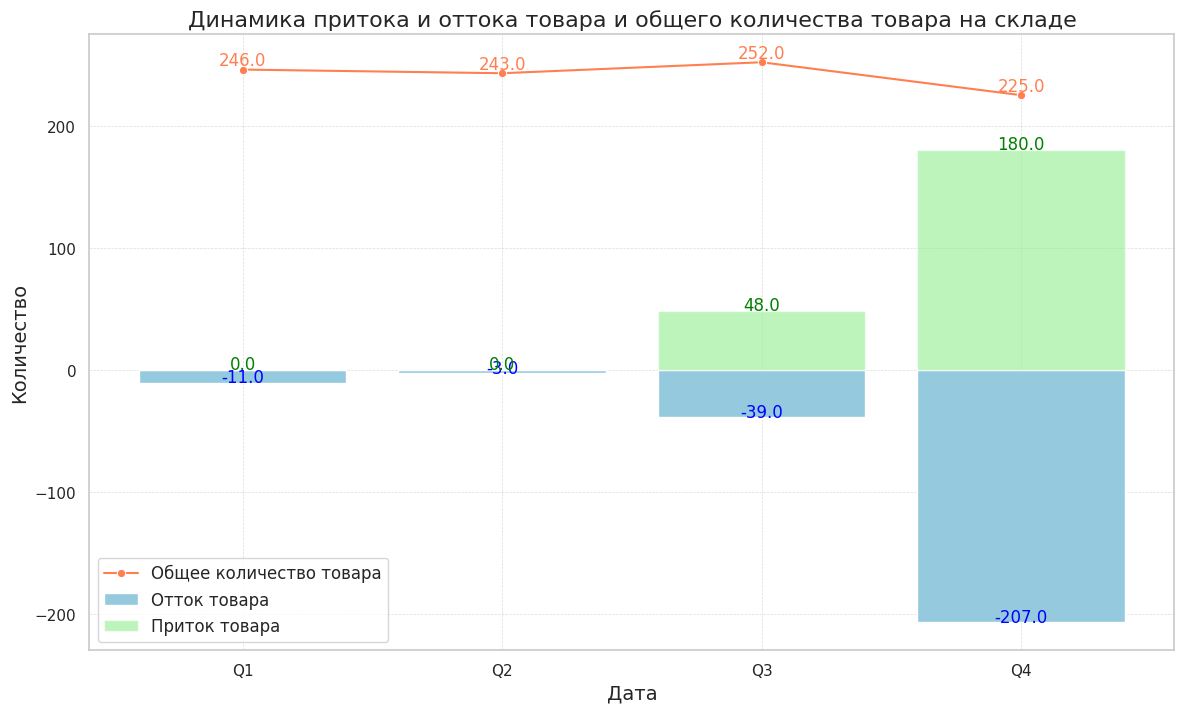

In [57]:
import io

dates = df['report_date']
turnovers_credit = df['turnovers_credit_quantity']*-1
turnovers_debit = df['turnovers_debit_quantity']
saldo_end = df['saldo_end_debit_quantity']

# Создание графика
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Bar chart для turnovers_credit_quantity
ax = sns.barplot(x=dates, y=turnovers_credit, color='skyblue', label='Отток товара')
ax.bar(dates, turnovers_debit, color='lightgreen', label='Приток товара', alpha=0.6)

# Добавление числовых меток на столбцы
for index, value in enumerate(turnovers_credit):
    ax.text(index, value + 0.5, f'{value}', color='blue', ha="center")
for index, value in enumerate(turnovers_debit):
    ax.text(index, value + 0.5, f'{value}', color='green', ha="center")

# Линия для saldo_end_debit_quantity
sns.lineplot(x=dates, y=saldo_end, marker='o', color='coral', label='Общее количество товара', ax=ax)

# Добавление числовых меток на линию
for index, value in enumerate(saldo_end):
    plt.text(index, value, f'{value}', color='coral', ha="center", va="bottom")

# Настройка легенды и цветов
ax.legend(loc='lower left', fontsize=12)

# Названия осей и заголовок
ax.set_xlabel('Дата', fontsize=14)
ax.set_ylabel('Количество', fontsize=14)
plt.title('Динамика притока и оттока товара и общего количества товара на складе', fontsize=16)

# Полупрозрачная сетка
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)

In [32]:
import json
json.dumps({'img': buf.getvalue().decode()})


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x05x\x00\x00\x03 \x08\x06\x00\x00\x00\x99\x06\n\x97\x00\x00\x009tEXtSoftware\x00Matplotlib version3.9.0, https://matplotlib.org/4\x04H\xb6\x00\x00\x00\tpHYs\x00\x00\x0fa\x00\x00\x0fa\x01\xa8?\xa7i\x00\x00\xee\xfaIDATx\x9c\xec\xddw|\x14u\xfe\xc7\xf1\xf7\xa6\xf7@H\x08\x11\x90v\x86&U\x05Q@A\x14\xc5^\xef\xceSP\x7fv\xc5r\x16\xac\x9c\xed,g\x17\xcb\x9dX\x01=\x0b\x8a\x15\xb0\x80\x8a\x08\x07\xd2A\xa4HQJ\x08!\x10R7\xbbI\xe6\xf7\xc7\xb0\xbb\xd9\xecnz2\x13x=\x1f\x8f< 3\xb3\xb3\x9f\x99\x9d\xfdd\xf6\xb3\xdf\xf9\x8c\xc30\x0cC\x00\x00\x00\x00\x00\x00\x00\x80\x16\'\xcc\xea\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf5C\x81\x17\x00\x00\x00\x00\x00\x00\x00Z(\n\xbc\x00\x00\x00\x00\x00\x00\x00\xd0BQ\xe0\x05\x00\x00\x00\x00\x00\x00\x80\x16\x8a\x02/\x00\x00\x00\x00\x00\x00\x00\xb4P\x14x\x01\x00\x00\x00\x00\x00\x00\xa0\x85\xa2\xc0\x0b\x00\x00\x00\x00\x00\x00\x00-\x14\x05^\x00\x00\x00\x00\x00\x00\x00h\xa1(\xf0\x02\x00\x00\x00\x00\x00\x00@\x0bE\x81\x17\x00\x00\x00\x00\x00

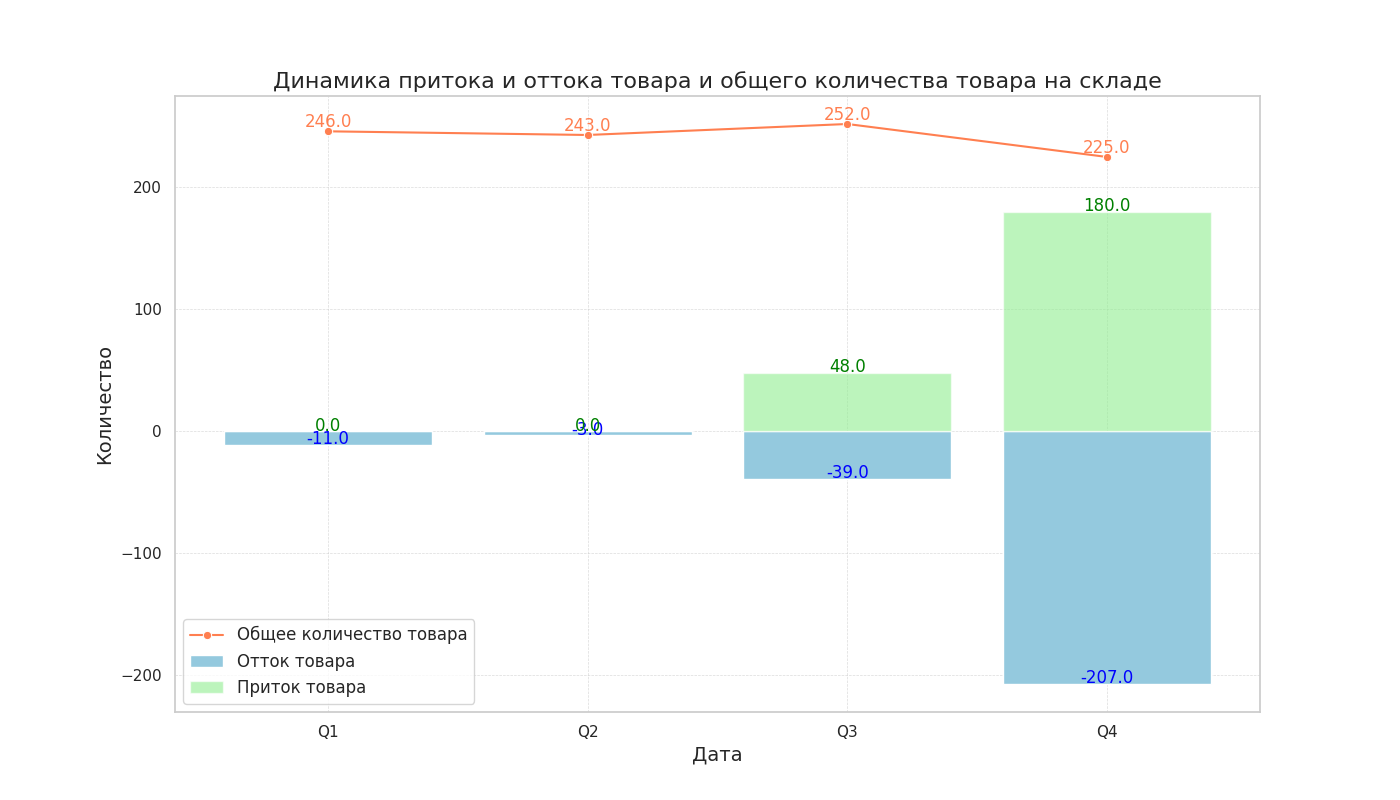

In [50]:
import base64
import json

buf_value = buf.getvalue()
print(buf_value)
val = base64.b64encode(buf_value).decode()
print(json.dumps({'1': val}))
print(val)
Image.open(io.BytesIO(base64.b64decode(val.encode())))

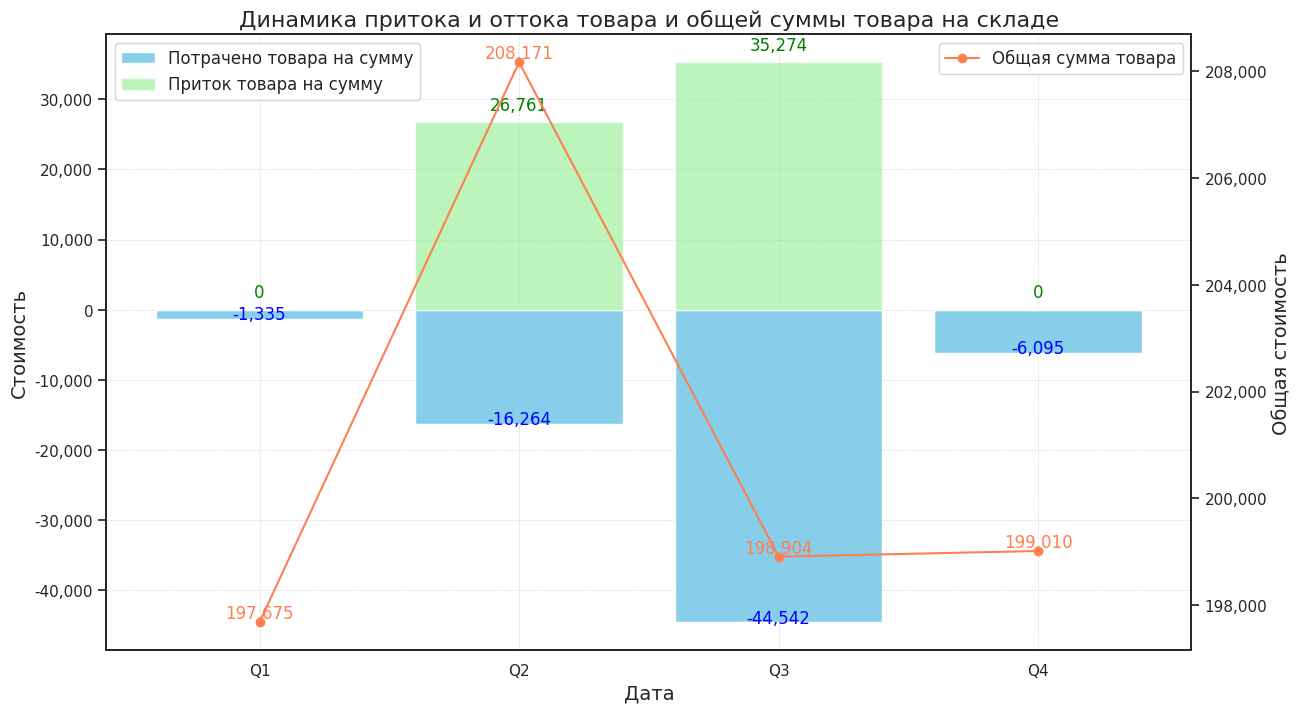

In [82]:
dates = df['report_date']
turnovers_credit = df['turnovers_credit_price'] * -1
turnovers_debit = df['turnovers_debit_price']
saldo_end = df['saldo_end_debit_price']


# Создание графика
fig, ax = plt.subplots(figsize=(14, 8))
sns.set(style="white")

# Bar chart для turnovers_credit_quantity
ax.bar(dates, turnovers_credit, color='skyblue', label='Потрачено товара на сумму')
ax.bar(dates, turnovers_debit, color='lightgreen', label='Приток товара на сумму', alpha=0.6)

# Добавление числовых меток на столбцы
for index, value in enumerate(turnovers_credit):
    ax.text(index, value + 0.05 * max(turnovers_credit), f'{int(value):,}', color='blue', ha="center")
for index, value in enumerate(turnovers_debit):
    ax.text(index, value + 0.05 * max(turnovers_debit), f'{int(value):,}', color='green', ha="center")

# Линия для saldo_end_debit_quantity
ax2 = ax.twinx()
ax2.plot(dates, saldo_end, marker='o', color='coral', label='Общая сумма товара')

# Добавление числовых меток на линию
for index, value in enumerate(saldo_end):
    ax2.text(index, value, f'{int(value):,}', color='coral', ha="center", va="bottom")

# Настройка легенды и цветов
ax.legend(loc='upper left', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)

# Названия осей и заголовок
ax.set_xlabel('Дата', fontsize=14)
ax.set_ylabel('Стоимость', fontsize=14)
ax2.set_ylabel('Общая стоимость', fontsize=14)
plt.title('Динамика притока и оттока товара и общей суммы товара на складе', fontsize=16)

# Полупрозрачная сетка
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Функция для форматирования чисел с разделением разрядов
def millions_formatter(x, pos):
    return f'{int(x):,}'

# Применение форматирования к оси y на обеих шкалах
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax2.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.show()

# Визуализация прогноза

## Прогноз по financial_data

In [65]:
df = sql_client.select_df("""
select 	spgz_name,
		date_trunc('quarter', start_report_date_quarter) + interval '3 month' as report_date,
        sum(turnovers_debit_quantity) as turnovers_debit_quantity,
        sum(turnovers_debit_price) as turnovers_debit_price,
		sum(turnovers_credit_quantity) as turnovers_credit_quantity,
		sum(turnovers_credit_price) as turnovers_credit_price,
		sum(saldo_end_debit_quantity) as saldo_end_debit_quantity,
		sum(saldo_end_debit_price) as saldo_end_debit_price,
		max(last_saldo_end_debit_quantity) as last_saldo_end_debit_quantity,
		max(last_saldo_end_debit_price) as last_saldo_end_debit_price
	from financial_quarter_data
	where spgz_name = 'Адаптер (переходник) USB-COM, шт'
	group by spgz_name, date_trunc('quarter', start_report_date_quarter)
	order by spgz_name, date_trunc('quarter', start_report_date_quarter);
""")
df

,spgz_name,report_date,turnovers_debit_quantity,turnovers_debit_price,turnovers_credit_quantity,turnovers_credit_price,saldo_end_debit_quantity,saldo_end_debit_price,last_saldo_end_debit_quantity,last_saldo_end_debit_price
0,"Адаптер (переходник) USB-COM, шт",2022-01-01 00:00:00+00:00,0,0,11.00,6095.13,246.00,199010.74,225.00,198904.75
1,"Адаптер (переходник) USB-COM, шт",2022-04-01 00:00:00+00:00,0,0,3.00,1335.61,243.00,197675.13,225.00,198904.75
2,"Адаптер (переходник) USB-COM, шт",2022-07-01 00:00:00+00:00,48.00,26761.72,39.00,16264.93,252.00,208171.92,225.00,198904.75
3,"Адаптер (переходник) USB-COM, шт",2022-10-01 00:00:00+00:00,180.00,35274.95,207.00,44542.12,225.00,198904.75,225.00,198904.75


In [66]:
df['report_date'] = df['report_date'].dt.quarter.apply(lambda x: f'2022-Q{x}')

cols_to_convert = [
    'turnovers_debit_quantity',
       'turnovers_debit_price', 'turnovers_credit_quantity',
       'turnovers_credit_price', 'saldo_end_debit_quantity',
       'saldo_end_debit_price', 'last_saldo_end_debit_quantity',
       'last_saldo_end_debit_price'
]

df[cols_to_convert] = df[cols_to_convert].astype(float)
df = df.sort_values(by='report_date')

In [67]:
df

,spgz_name,report_date,turnovers_debit_quantity,turnovers_debit_price,turnovers_credit_quantity,turnovers_credit_price,saldo_end_debit_quantity,saldo_end_debit_price,last_saldo_end_debit_quantity,last_saldo_end_debit_price
0,"Адаптер (переходник) USB-COM, шт",2022-Q1,0.0,0.00,11.0,6095.13,246.0,199010.74,225.0,198904.75
1,"Адаптер (переходник) USB-COM, шт",2022-Q2,0.0,0.00,3.0,1335.61,243.0,197675.13,225.0,198904.75
2,"Адаптер (переходник) USB-COM, шт",2022-Q3,48.0,26761.72,39.0,16264.93,252.0,208171.92,225.0,198904.75
3,"Адаптер (переходник) USB-COM, шт",2022-Q4,180.0,35274.95,207.0,44542.12,225.0,198904.75,225.0,198904.75


In [68]:
predict_month = np.mean(df['turnovers_debit_quantity'])/3
predict_q = predict_month *3
predict_y = predict_month*12

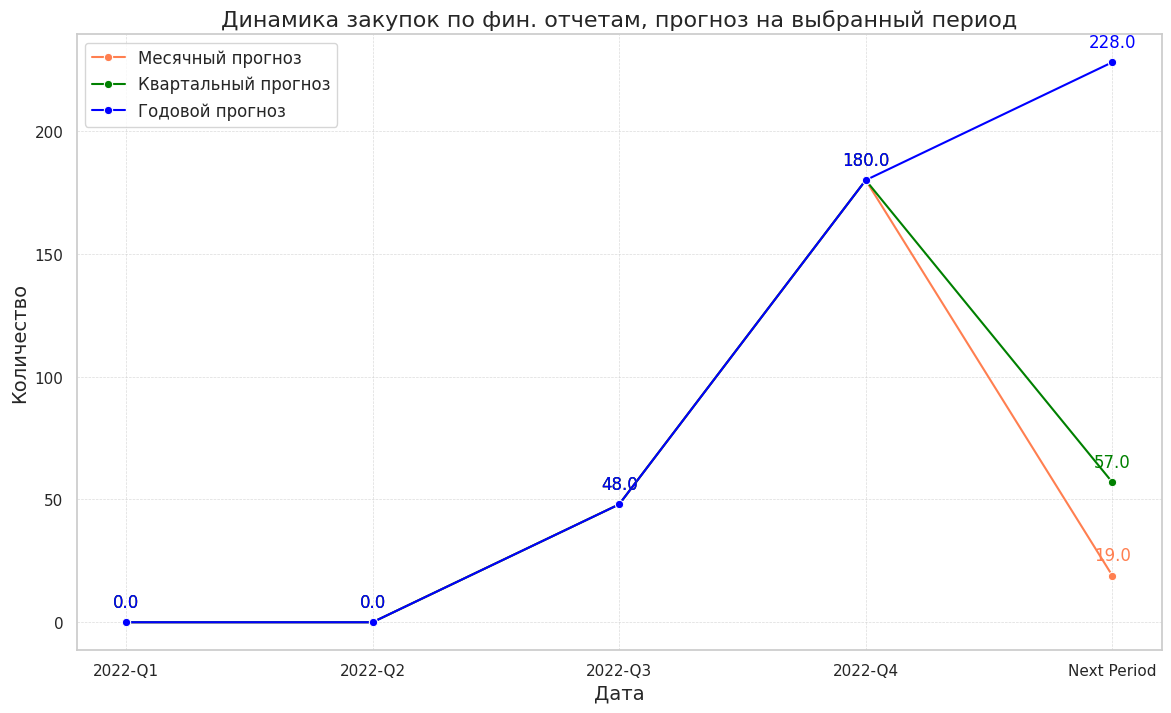

In [86]:
dates = df['report_date'].to_list()
dates.append('Next Period')

turnovers_debit = df['turnovers_debit_quantity'].to_list()
turnovers_debit_m = df['turnovers_debit_quantity'].to_list()
turnovers_debit_m.append(predict_month)
turnovers_debit_q = df['turnovers_debit_quantity'].to_list()
turnovers_debit_q.append(predict_q)
turnovers_debit_y = df['turnovers_debit_quantity'].to_list()
turnovers_debit_y.append(predict_y)

plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Линия для turnovers_debit_m
ax = sns.lineplot(x=dates, y=turnovers_debit_m, marker='o', color='coral', label='Месячный прогноз')

# Добавление числовых меток на линию turnovers_debit_m
for index, value in enumerate(turnovers_debit_m):
    plt.text(index, value + 0.025 * max(turnovers_debit_m), f'{value}', color='coral', ha="center", va="bottom")

# Линия для turnovers_debit_q
sns.lineplot(x=dates, y=turnovers_debit_q, marker='o', color='green', label='Квартальный прогноз', ax=ax)

# Добавление числовых меток на линию turnovers_debit_q
for index, value in enumerate(turnovers_debit_q):
    plt.text(index, value + 0.025 * max(turnovers_debit_m), f'{value}', color='green', ha="center", va="bottom")

    # Линия для turnovers_debit_q
sns.lineplot(x=dates, y=turnovers_debit_y, marker='o', color='blue', label='Годовой прогноз', ax=ax)

# Добавление числовых меток на линию turnovers_debit_q
for index, value in enumerate(turnovers_debit_y):
    plt.text(index, value + 0.025 * max(turnovers_debit_m) , f'{value}', color='blue', ha="center", va="bottom")

# Настройка легенды и цветов
ax.legend(loc='upper left', fontsize=12)

# Названия осей и заголовок
ax.set_xlabel('Дата', fontsize=14)
ax.set_ylabel('Количество', fontsize=14)
plt.title(f'Динамика закупок по фин. отчетам, прогноз на выбранный период', fontsize=16)

# Полупрозрачная сетка
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()

## Прогноз по контрактам

In [87]:
spgz_name = 'Скобы для степлера'
date_grain = 'month'
sql = f"""
with dates as (
select distinct date_trunc('{ date_grain }', generate_series('2018-01-09'::date, '2023-01-01', interval '1 day')) as date
),
contracts_raw_delta as (
select 	
	spgz_name,
	date_trunc('{ date_grain }', contract_date) as contract_date,
	sum(contracts_price) as contracts_price,
	coalesce(
		age(lead(date_trunc('{ date_grain }', contract_date)) over(order by date_trunc('{ date_grain }', contract_date)), date_trunc('{date_grain }', contract_date)),
		age('2023-01-01'::date, date_trunc('{ date_grain}', contract_date))
	) as delta
from procurement_contracts_date_data
where spgz_name = '{ spgz_name }'
group by spgz_name, date_trunc('{ date_grain }', contract_date)
),
contracts as (
select 
	spgz_name,
	contract_date,
	contracts_price,
	extract(year from delta)*12 + extract(month from delta) as delta
from contracts_raw_delta
)
select 	
	'{spgz_name}' as spgz_name,
	t.date as contract_date,
	coalesce(contracts_price, 0) as contracts_price,
	coalesce(tt.delta, 0) as delta,
	case 
		when coalesce(tt.delta, 0) = 0 then 0 
		else round(coalesce(contracts_price, 0) / coalesce(tt.delta, 0), 2) 
	end as price_per_1_delta
from dates t
left join contracts tt on t.date = tt.contract_date
order by t.date
;
"""
df = sql_client.select_df(sql)
contracts_df = df[df['contracts_price'] > 0]
contracts_df

,spgz_name,contract_date,contracts_price,delta,price_per_1_delta
4,Скобы для степлера,2018-05-01 00:00:00+00:00,1334615.26,13,102662.71
17,Скобы для степлера,2019-06-01 00:00:00+00:00,393706.20,17,23159.19
34,Скобы для степлера,2020-11-01 00:00:00+00:00,452308.03,18,25128.22
52,Скобы для степлера,2022-05-01 00:00:00+00:00,1794658.14,6,299109.69
58,Скобы для степлера,2022-11-01 00:00:00+00:00,201699.25,2,100849.63


In [88]:
contracts_df['contract_date'] = pd.to_datetime(df['contract_date'])

contracts_df['contract_date_formatted'] = contracts_df['contract_date'].dt.to_period('Q').astype(str).str.replace('Q', '-Q')
contracts_df

/tmp/ipykernel_1462009/1417650193.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contracts_df['contract_date'] = pd.to_datetime(df['contract_date'])
/tmp/ipykernel_1462009/1417650193.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  contracts_df['contract_date_formatted'] = contracts_df['contract_date'].dt.to_period('Q').astype(str).str.replace('Q', '-Q')
/tmp/ipykernel_1462009/1417650193.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contracts_df[

,spgz_name,contract_date,contracts_price,delta,price_per_1_delta,contract_date_formatted
4,Скобы для степлера,2018-05-01 00:00:00+00:00,1334615.26,13,102662.71,2018-Q2
17,Скобы для степлера,2019-06-01 00:00:00+00:00,393706.20,17,23159.19,2019-Q2
34,Скобы для степлера,2020-11-01 00:00:00+00:00,452308.03,18,25128.22,2020-Q4
52,Скобы для степлера,2022-05-01 00:00:00+00:00,1794658.14,6,299109.69,2022-Q2
58,Скобы для степлера,2022-11-01 00:00:00+00:00,201699.25,2,100849.63,2022-Q4


In [91]:
contracts_df.columns

Index(['spgz_name', 'contract_date', 'contracts_price', 'delta',
       'price_per_1_delta', 'contract_date_formatted'],
      dtype='object')

In [93]:
contracts_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 4 to 58
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   spgz_name                5 non-null      object             
 1   contract_date            5 non-null      datetime64[ns, UTC]
 2   contracts_price          5 non-null      float64            
 3   delta                    5 non-null      float64            
 4   price_per_1_delta        5 non-null      float64            
 5   contract_date_formatted  5 non-null      object             
dtypes: datetime64[ns, UTC](1), float64(3), object(2)
memory usage: 280.0+ bytes


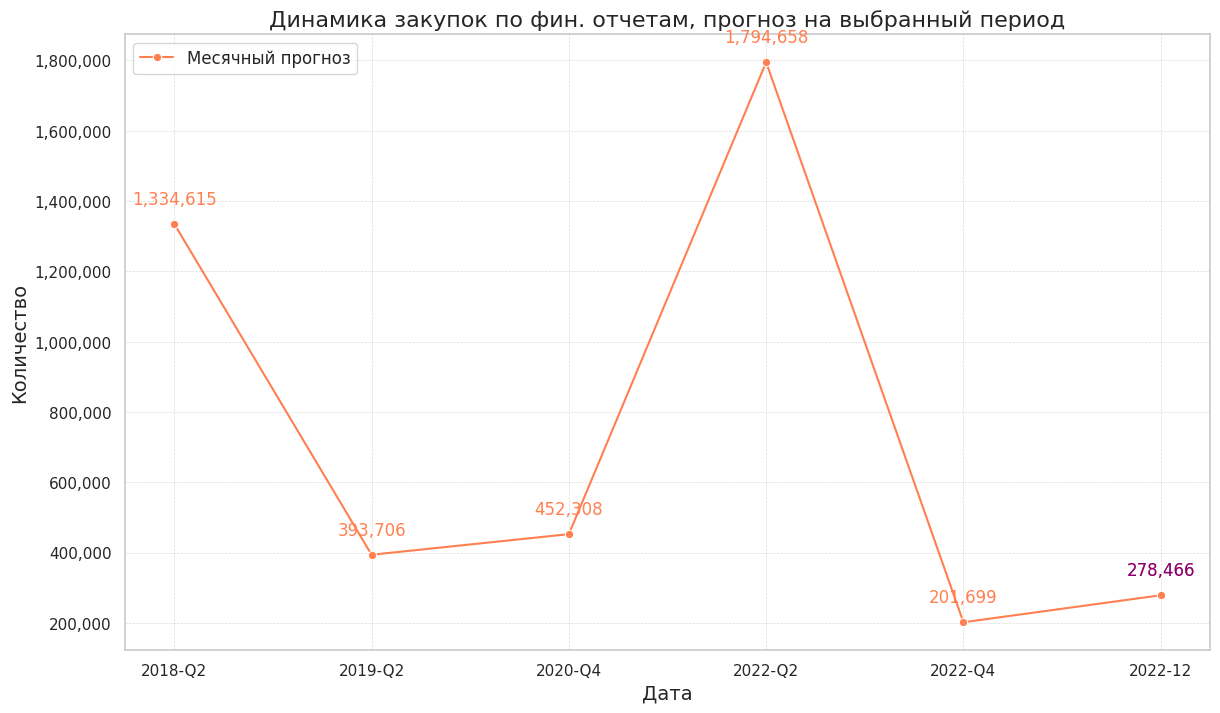

In [103]:
month = 1
day = 0
year = 0

predict_month = np.mean(contracts_df['contracts_price']) / 3
predict_q = predict_month * 3
predict_y = predict_month * 12

# Создание списков дат и значений
dates = contracts_df['contract_date_formatted'].to_list()
dates.append((pd.to_datetime(contracts_df["contract_date"].to_list()[-1]) + pd.DateOffset(months=month, days=day, years=year)).strftime('%Y-%m'))

contracts_price_m = contracts_df['contracts_price'].to_list()
contracts_price_m.append(predict_month)

contracts_price_q = contracts_df['contracts_price'].to_list()
contracts_price_q.append(predict_q)

contracts_price_y = contracts_df['contracts_price'].to_list()
contracts_price_y.append(predict_y)

# Создание графика
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Выбор цвета для последнего значения
last_value_color = 'purple'

# Определение основного графика
if month != 0:
    ax = sns.lineplot(x=dates, y=contracts_price_m, marker='o', color='coral', label='Месячный прогноз')
    text_color = 'coral'
    last_value_color = 'purple'

elif day != 0:
    sns.lineplot(x=dates, y=contracts_price_q, marker='o', color='green', label='Квартальный прогноз', ax=ax)
    text_color = 'green'
    last_value_color = 'purple'

else:
    sns.lineplot(x=dates, y=contracts_price_y, marker='o', color='blue', label='Годовой прогноз', ax=ax)
    text_color = 'blue'
    last_value_color = 'purple'

# Добавление числовых меток на график
for index, value in enumerate(contracts_price_m):
    formatted_value = '{:,.0f}'.format(value)  # Форматирование числа с разделением разрядов
    plt.text(index, value + 0.025 * max(contracts_price_m), f'{formatted_value}', color=text_color, ha="center", va="bottom")

# Добавление числовой метки для последнего значения другим цветом
plt.text(len(dates) - 1, contracts_price_m[-1] + 0.025 * max(contracts_price_m), f'{formatted_value}', color=last_value_color, ha="center", va="bottom")

# Настройка легенды и цветов
ax.legend(loc='upper left', fontsize=12)

# Названия осей и заголовок
ax.set_xlabel('Дата', fontsize=14)
ax.set_ylabel('Количество', fontsize=14)
plt.title(f'Динамика закупок по фин. отчетам, прогноз на выбранный период', fontsize=16)

# Полупрозрачная сетка
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Отключение научного формата оси Y
ax.yaxis.set_major_formatter('{x:,.0f}')

plt.show()

In [7]:
df['turnovers_credit_quantity'].mean()

11.0

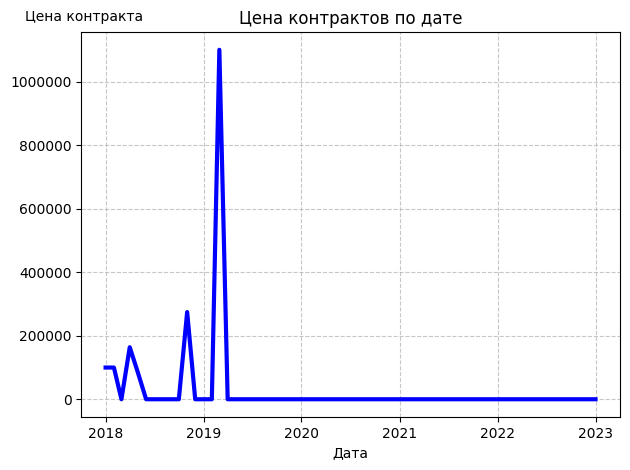

In [90]:
df['contract_date'] = pd.to_datetime(df['contract_date'])
df['contracts_price'] = df['contracts_price'].astype('float')
ax = sns.lineplot(x='contract_date', y='contracts_price', data=df, color='blue', linewidth=3)
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.text(0.005, 1.03, 'Цена контракта', transform=ax.transAxes, fontsize=10, ha='center')

plt.title("Цена контрактов по дате")
plt.xlabel('Дата')
plt.ylabel('')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

19:29:12 - cmdstanpy - INFO - Chain [1] start processing
19:29:12 - cmdstanpy - INFO - Chain [1] done processing
/home/ubuntu/lct_hack/.venv/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/ubuntu/lct_hack/.venv/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


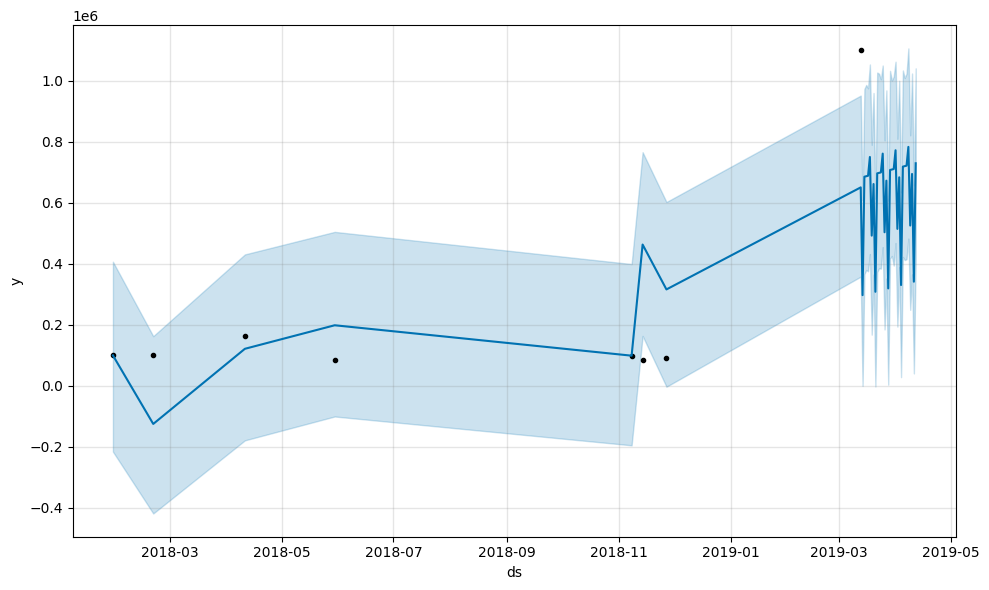

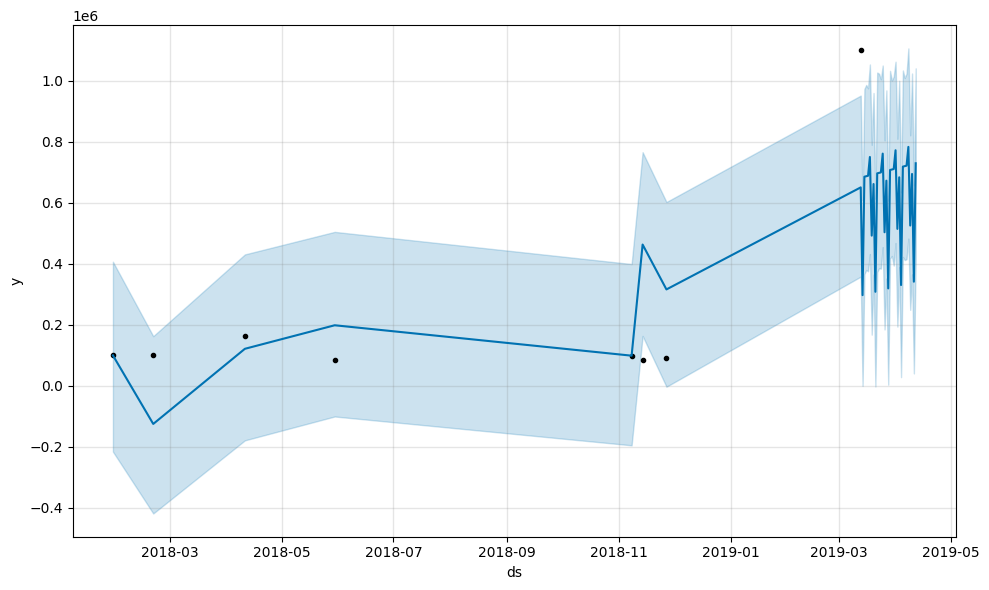

In [26]:
predict_df = df[['contract_date', 'contracts_price']]
predict_df = predict_df.rename(columns={'contract_date': 'ds', 'contracts_price': 'y'})
predict_df['ds'] = pd.to_datetime(predict_df['ds'])
predict_df['y'] = predict_df['y'].astype('float')
m = Prophet()
m.fit(predict_df)
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
m.plot(forecast)

<Axes: xlabel='contract_date', ylabel='contracts_price'>

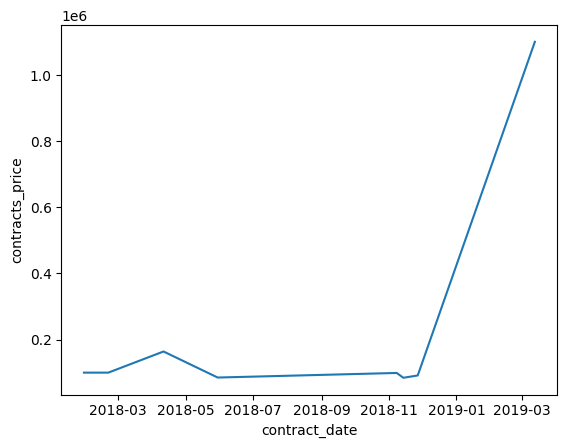

In [7]:
seaborn.lineplot(data=df, x='contract_date', y='contracts_price')